# 1: IMPORT LIBRARIES AND DATASETS

In [1]:
import nltk
nltk.download('punkt_tab')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 


[nltk_data] Downloading package punkt_tab to /home/bao-
[nltk_data]     long/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
2025-12-11 11:31:33.810769: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-11 11:31:33.861636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 11:31:35.164999: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# load the data
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

In [3]:
df_true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [4]:
df_fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [7]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [8]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


# 2: PERFORM EXPLORATORY DATA ANALYSIS

In [9]:
# add a target class column to indicate whether the news is real or fake
df_true['isfake'] = 0
df_true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  isfake  
0  December 31, 2017        0  
1  December 29, 2017        0  
2  December 31, 2017        0  
3  December 30, 2017        0  
4  December 29, 2017        0

In [10]:
df_fake['isfake'] = 1
df_fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  isfake  
0  December 31, 2017       1  
1  December 31, 2017       1  
2  December 30, 2017       1  
3  December 29, 2017       1  
4  December 25, 2017       1

In [11]:
# Concatenate Real and Fake News
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  isfake  
0      December 31, 2017        0  
1      December 29, 2017        0  
2      December 31, 2017        0  
3      December 30, 2017        0  
4      December 29, 2017        0  
...                   ...     ...  
44893    January 16, 2016       1  
44894    January 16, 2016       1  
44895    January 15, 2016       1  
44896    January 14, 2016       1  
44897    January 12, 2016       1  

[44898 rows x 5 columns]

In [12]:
df.drop(columns = ['date'], inplace = True)

In [13]:
# combine title and text together
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  isfake  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews       0   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews       0   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews       0   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews       0   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews       0   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

In [14]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

# 3: PERFORM DATA CLEANING

In [15]:
# download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/bao-
[nltk_data]     long/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [17]:
stop_words

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [18]:
# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [19]:
# Apply the function to the dataframe
df['clean'] = df['original'].apply(preprocess)

In [20]:
# Show original news
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [21]:
# Show cleaned up news after removing stopwords
print(df['clean'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [22]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isfake                                           original  \
0           0  As U.S. budget fight looms, Republicans flip t...   
1           0  U.S. military to accept transgender recruits o...   
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...   
3           0  FBI Russia probe helped by Australian diplomat...   
4           0  Trump wants Postal Service to charge 'much mor...   
...       ...                                                ...   
44893       1  McPain: John McCain Furious That Iran Treated ...   
44894       1  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895       1  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896       1  How to Blow $700 Million: Al Jazeera America F...   
44897       1  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                   clean  
0      [budget, fight, looms, republicans, flip, fisc...  
1      [military, accept, transgender, recruits, mond...  
2      [senior, republican, senator, mueller, washing...  
3      [russia, probe, helped, australian, diplomat, ...  
4      [trump, wants, postal, service, charge, amazon...  
...                                                  ...  
44893  [mcpain, john, mccain, furious, iran, treated,...  
44894  [justice, yahoo, settles, mail, privacy, class...  
44895  [sunnistan, allied, safe, zone, plan, territor...  
44896  [blow, million, jazeera, america, finally, cal...  
44897  [navy, sailors, held, iranian, military, signs...  

[44898 rows x 6 columns]

In [23]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)


In [24]:
list_of_words

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [25]:
len(list_of_words)

9276947

In [26]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

108704

In [27]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [28]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isfake                                           original  \
0           0  As U.S. budget fight looms, Republicans flip t...   
1           0  U.S. military to accept transgender recruits o...   
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...   
3           0  FBI Russia probe helped by Australian diplomat...   
4           0  Trump wants Postal Service to charge 'much mor...   
...       ...                                                ...   
44893       1  McPain: John McCain Furious That Iran Treated ...   
44894       1  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895       1  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896       1  How to Blow $700 Million: Al Jazeera America F...   
44897       1  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                   clean  \
0      [budget, fight, looms, republicans, flip, fisc...   
1      [military, accept, transgender, recruits, mond...   
2      [senior, republican, senator, mueller, washing...   
3      [russia, probe, helped, australian, diplomat, ...   
4      [trump, wants, postal, service, charge, amazon...   
...                                                  ...   
44893  [mcpain, john, mccain, furious, iran, treated,...   
44894  [justice, yahoo, settles, mail, privacy, class...   
44895  [sunnistan, allied, safe, zone, plan, territor...   
44896  [blow, million, jazeera, america, finally, cal...   
44897  [navy, sailors, held, iranian, military, signs...   

                                            clean_joined  
0      budget fight looms republicans flip fiscal scr...  
1      military accept transgender recruits monday pe...  
2      senior republican senator mueller washington r...  
3      russia probe helped australian diplomat washin...  
4      trump wants postal service charge amazon shipm...  
...                                                  ...  
44893  mcpain john mccain furious iran treated sailor...  
44894  justice yahoo settles mail privacy class actio...  
44895  sunnistan allied safe zone plan territorial bo...  
44896  blow million jazeera america finally calls qui...  
44897  navy sailors held iranian military signs neoco...  

[44898 rows x 7 columns]

In [29]:
df['clean_joined'][0]

'budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying need government raise 

# 4: VISUALIZE CLEANED UP DATASET

In [30]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isfake                                           original  \
0           0  As U.S. budget fight looms, Republicans flip t...   
1           0  U.S. military to accept transgender recruits o...   
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...   
3           0  FBI Russia probe helped by Australian diplomat...   
4           0  Trump wants Postal Service to charge 'much mor...   
...       ...                                                ...   
44893       1  McPain: John McCain Furious That Iran Treated ...   
44894       1  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895       1  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896       1  How to Blow $700 Million: Al Jazeera America F...   
44897       1  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                   clean  \
0      [budget, fight, looms, republicans, flip, fisc...   
1      [military, accept, transgender, recruits, mond...   
2      [senior, republican, senator, mueller, washing...   
3      [russia, probe, helped, australian, diplomat, ...   
4      [trump, wants, postal, service, charge, amazon...   
...                                                  ...   
44893  [mcpain, john, mccain, furious, iran, treated,...   
44894  [justice, yahoo, settles, mail, privacy, class...   
44895  [sunnistan, allied, safe, zone, plan, territor...   
44896  [blow, million, jazeera, america, finally, cal...   
44897  [navy, sailors, held, iranian, military, signs...   

                                            clean_joined  
0      budget fight looms republicans flip fiscal scr...  
1      military accept transgender recruits monday pe...  
2      senior republican senator mueller washington r...  
3      russia probe helped australian diplomat washin...  
4      trump wants postal service charge amazon shipm...  
...                                                  ...  
44893  mcpain john mccain furious iran treated sailor...  
44894  justice yahoo settles mail privacy class actio...  
44895  sunnistan allied safe zone plan territorial bo...  
44896  blow million jazeera america finally calls qui...  
44897  navy sailors held iranian military signs neoco...  

[44898 rows x 7 columns]

<Axes: xlabel='count', ylabel='subject'>

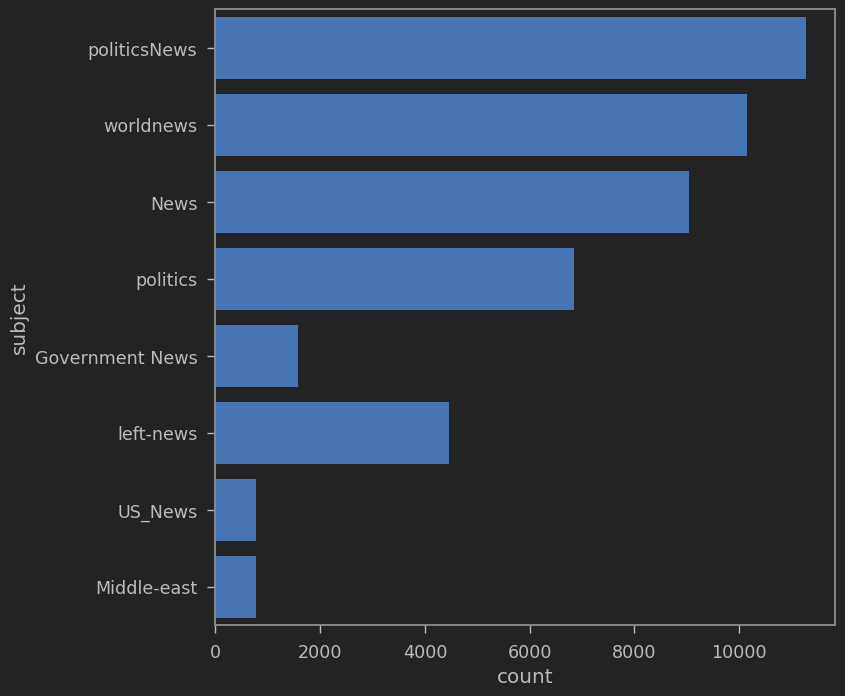

In [31]:
# plot the number of samples in 'subject'
plt.figure(figsize = (8, 8))
sns.countplot(y = "subject", data = df)

<Axes: xlabel='count', ylabel='isfake'>

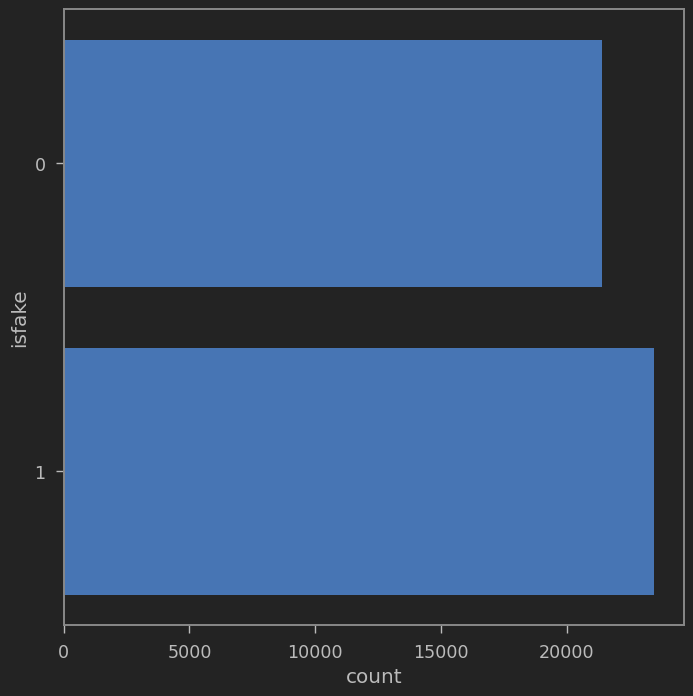

In [32]:
# Plot the count plot for fake vs. true news
plt.figure(figsize = (8, 8))
sns.countplot(y = "isfake", data = df)

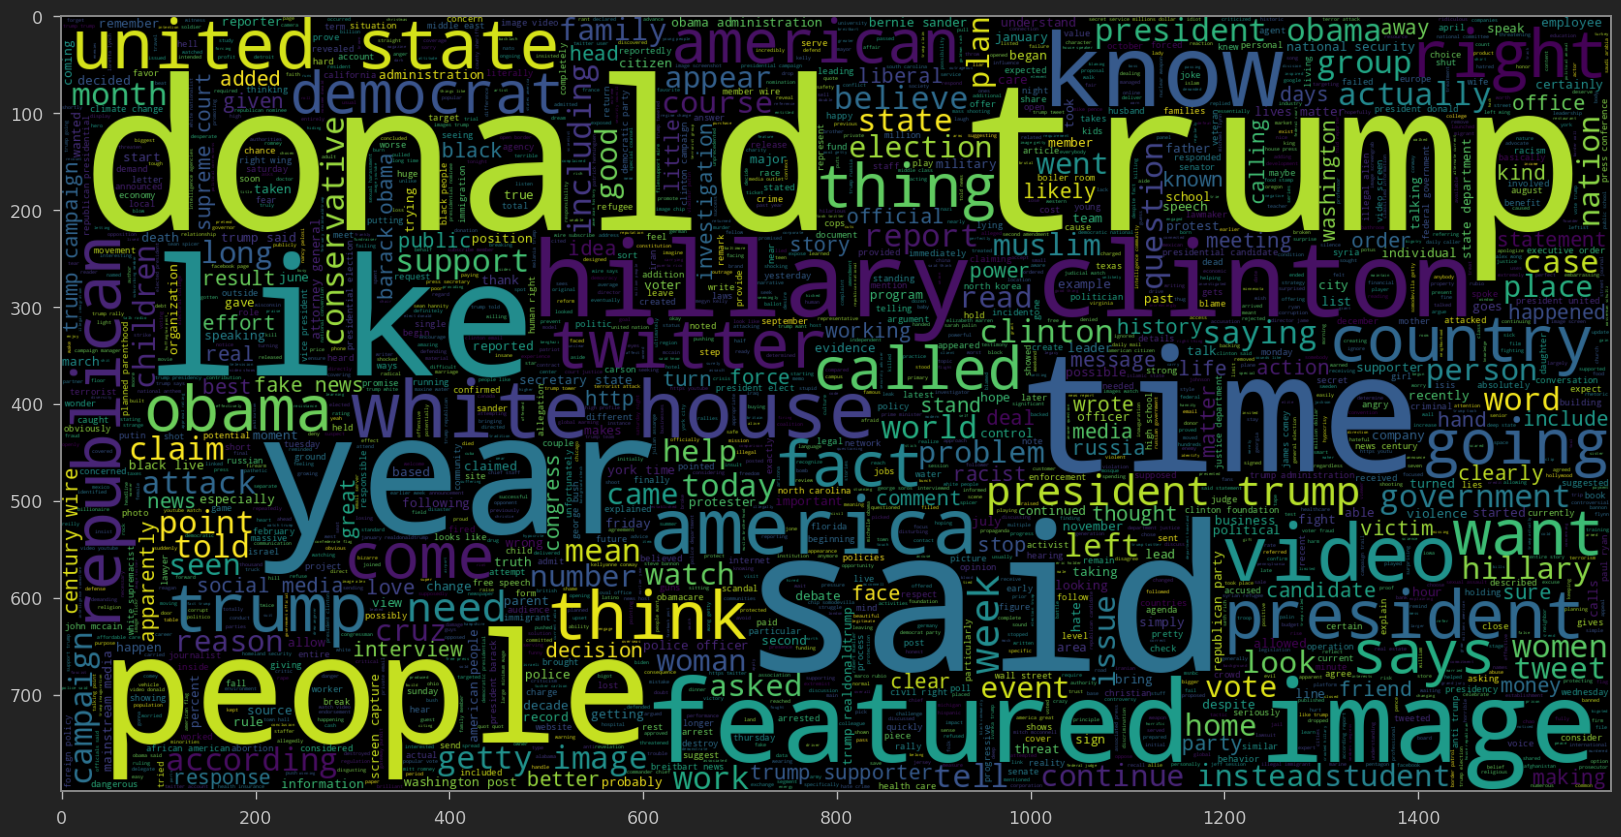

In [33]:
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

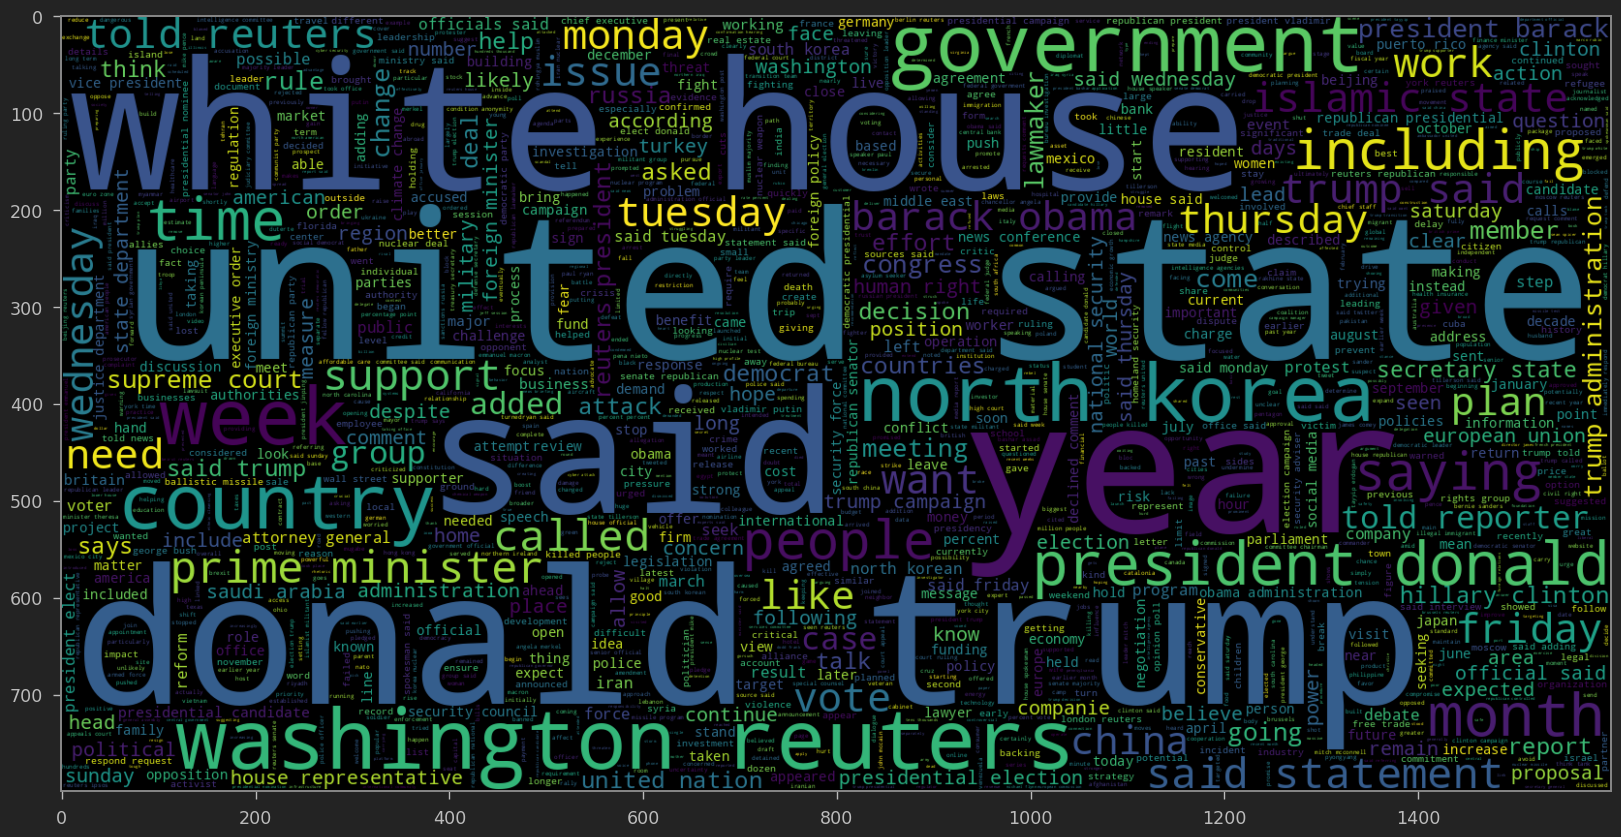

In [34]:
# plot the word cloud for text that is Fake
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [35]:
nltk.word_tokenize(df['clean_joined'][0])

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [36]:
# length of maximum document will be needed to create word embeddings 
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


In [37]:
import plotly.express as px
fig = px.histogram(x= [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

# 5: PREPARE THE DATA BY PERFORMING TOKENIZATION AND PADDING

In [38]:
# split data into test and train 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [39]:
from nltk import word_tokenize

In [40]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)


In [41]:
len(train_sequences)

35918

In [42]:
train_sequences

[[786,
  263,
  80,
  7317,
  594,
  11777,
  5722,
  280,
  1750,
  9,
  786,
  263,
  80,
  49517,
  3757,
  1042,
  594,
  162,
  5,
  688,
  11777,
  498,
  1333,
  26137,
  82,
  278,
  576,
  552,
  503,
  628,
  30527,
  11777,
  850,
  412,
  3835,
  54,
  234,
  1068,
  3961,
  1042,
  5893,
  1049,
  280,
  122,
  11777,
  10131,
  3757,
  2,
  67,
  162,
  5,
  1357,
  363,
  774,
  5459,
  1342,
  3961,
  26137,
  6159,
  390,
  2764,
  410,
  3388,
  4882,
  2971,
  54,
  688,
  173,
  725,
  914,
  304,
  786,
  155,
  1021,
  12287,
  79,
  3961,
  1750,
  786,
  55,
  2,
  334,
  850,
  786,
  364,
  1298,
  466,
  13726,
  12287,
  82,
  1152,
  848,
  2378,
  1316,
  10045,
  79,
  162,
  5,
  62,
  2,
  67,
  13726,
  846,
  848,
  728,
  208,
  688,
  2121,
  1460,
  353,
  627,
  956,
  184,
  786,
  222,
  1644,
  163,
  30527,
  1354,
  5460,
  11777,
  3479,
  1018,
  594,
  1316,
  162,
  5,
  688,
  11329,
  628,
  3421,
  786,
  364,
  66,
  33,
  412,
  3746

In [43]:
print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

In [69]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 200, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 200, padding='post', truncating='post')

In [70]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [  786   263    80  7317   594 11777  5722   280  1750     9   786   263
    80 49517  3757  1042   594   162     5   688 11777   498  1333 26137
    82   278   576   552   503   628 30527 11777   850   412  3835    54
   234  1068  3961  1042  5893  1049   280   122 11777 10131  3757     2
    67   162     5  1357   363   774  5459  1342  3961 26137  6159   390
  2764   410  3388  4882  2971    54   688   173   725   914   304   786
   155  1021 12287    79  3961  1750   786    55     2   334   850   786
   364  1298   466 13726 12287    82  1152   848  2378  1316 10045    79
   162     5    62     2    67 13726   846   848   728   208   688  2121
  1460   353   627   956   184   786   222  1644   163 30527  1354  5460
 11777  3479  1018   594  1316   162     5   688 11329   628  3421   786
   364    66    33   412  3746 11123 20041 30527    82    62   409    17
     9   144  8454  4205   552  4808  2493  1785   786   222   189   163
  1982   

# 6: BUILD AND TRAIN THE MODEL 

In [71]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [72]:
total_words

108704

In [73]:
y_train = np.asarray(y_train)

In [74]:
# train the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 ━━━━━━━━━━━━━━━━━━━━ 211s 410ms/step - acc: 0.9834 - loss: 0.0383 - val_acc: 0.9983 - val_loss: 0.0066
Epoch 2/2
506/506 ━━━━━━━━━━━━━━━━━━━━ 211s 417ms/step - acc: 0.9998 - loss: 0.0013 - val_acc: 0.9986 - val_loss: 0.0067


# 7: ASSESS TRAINED MODEL PERFORMANCE


In [75]:
# make prediction
pred = model.predict(padded_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step


In [76]:
# if the predicted value is >0.5 it is fake else it is real
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [77]:
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9985523385300669


<Axes: >

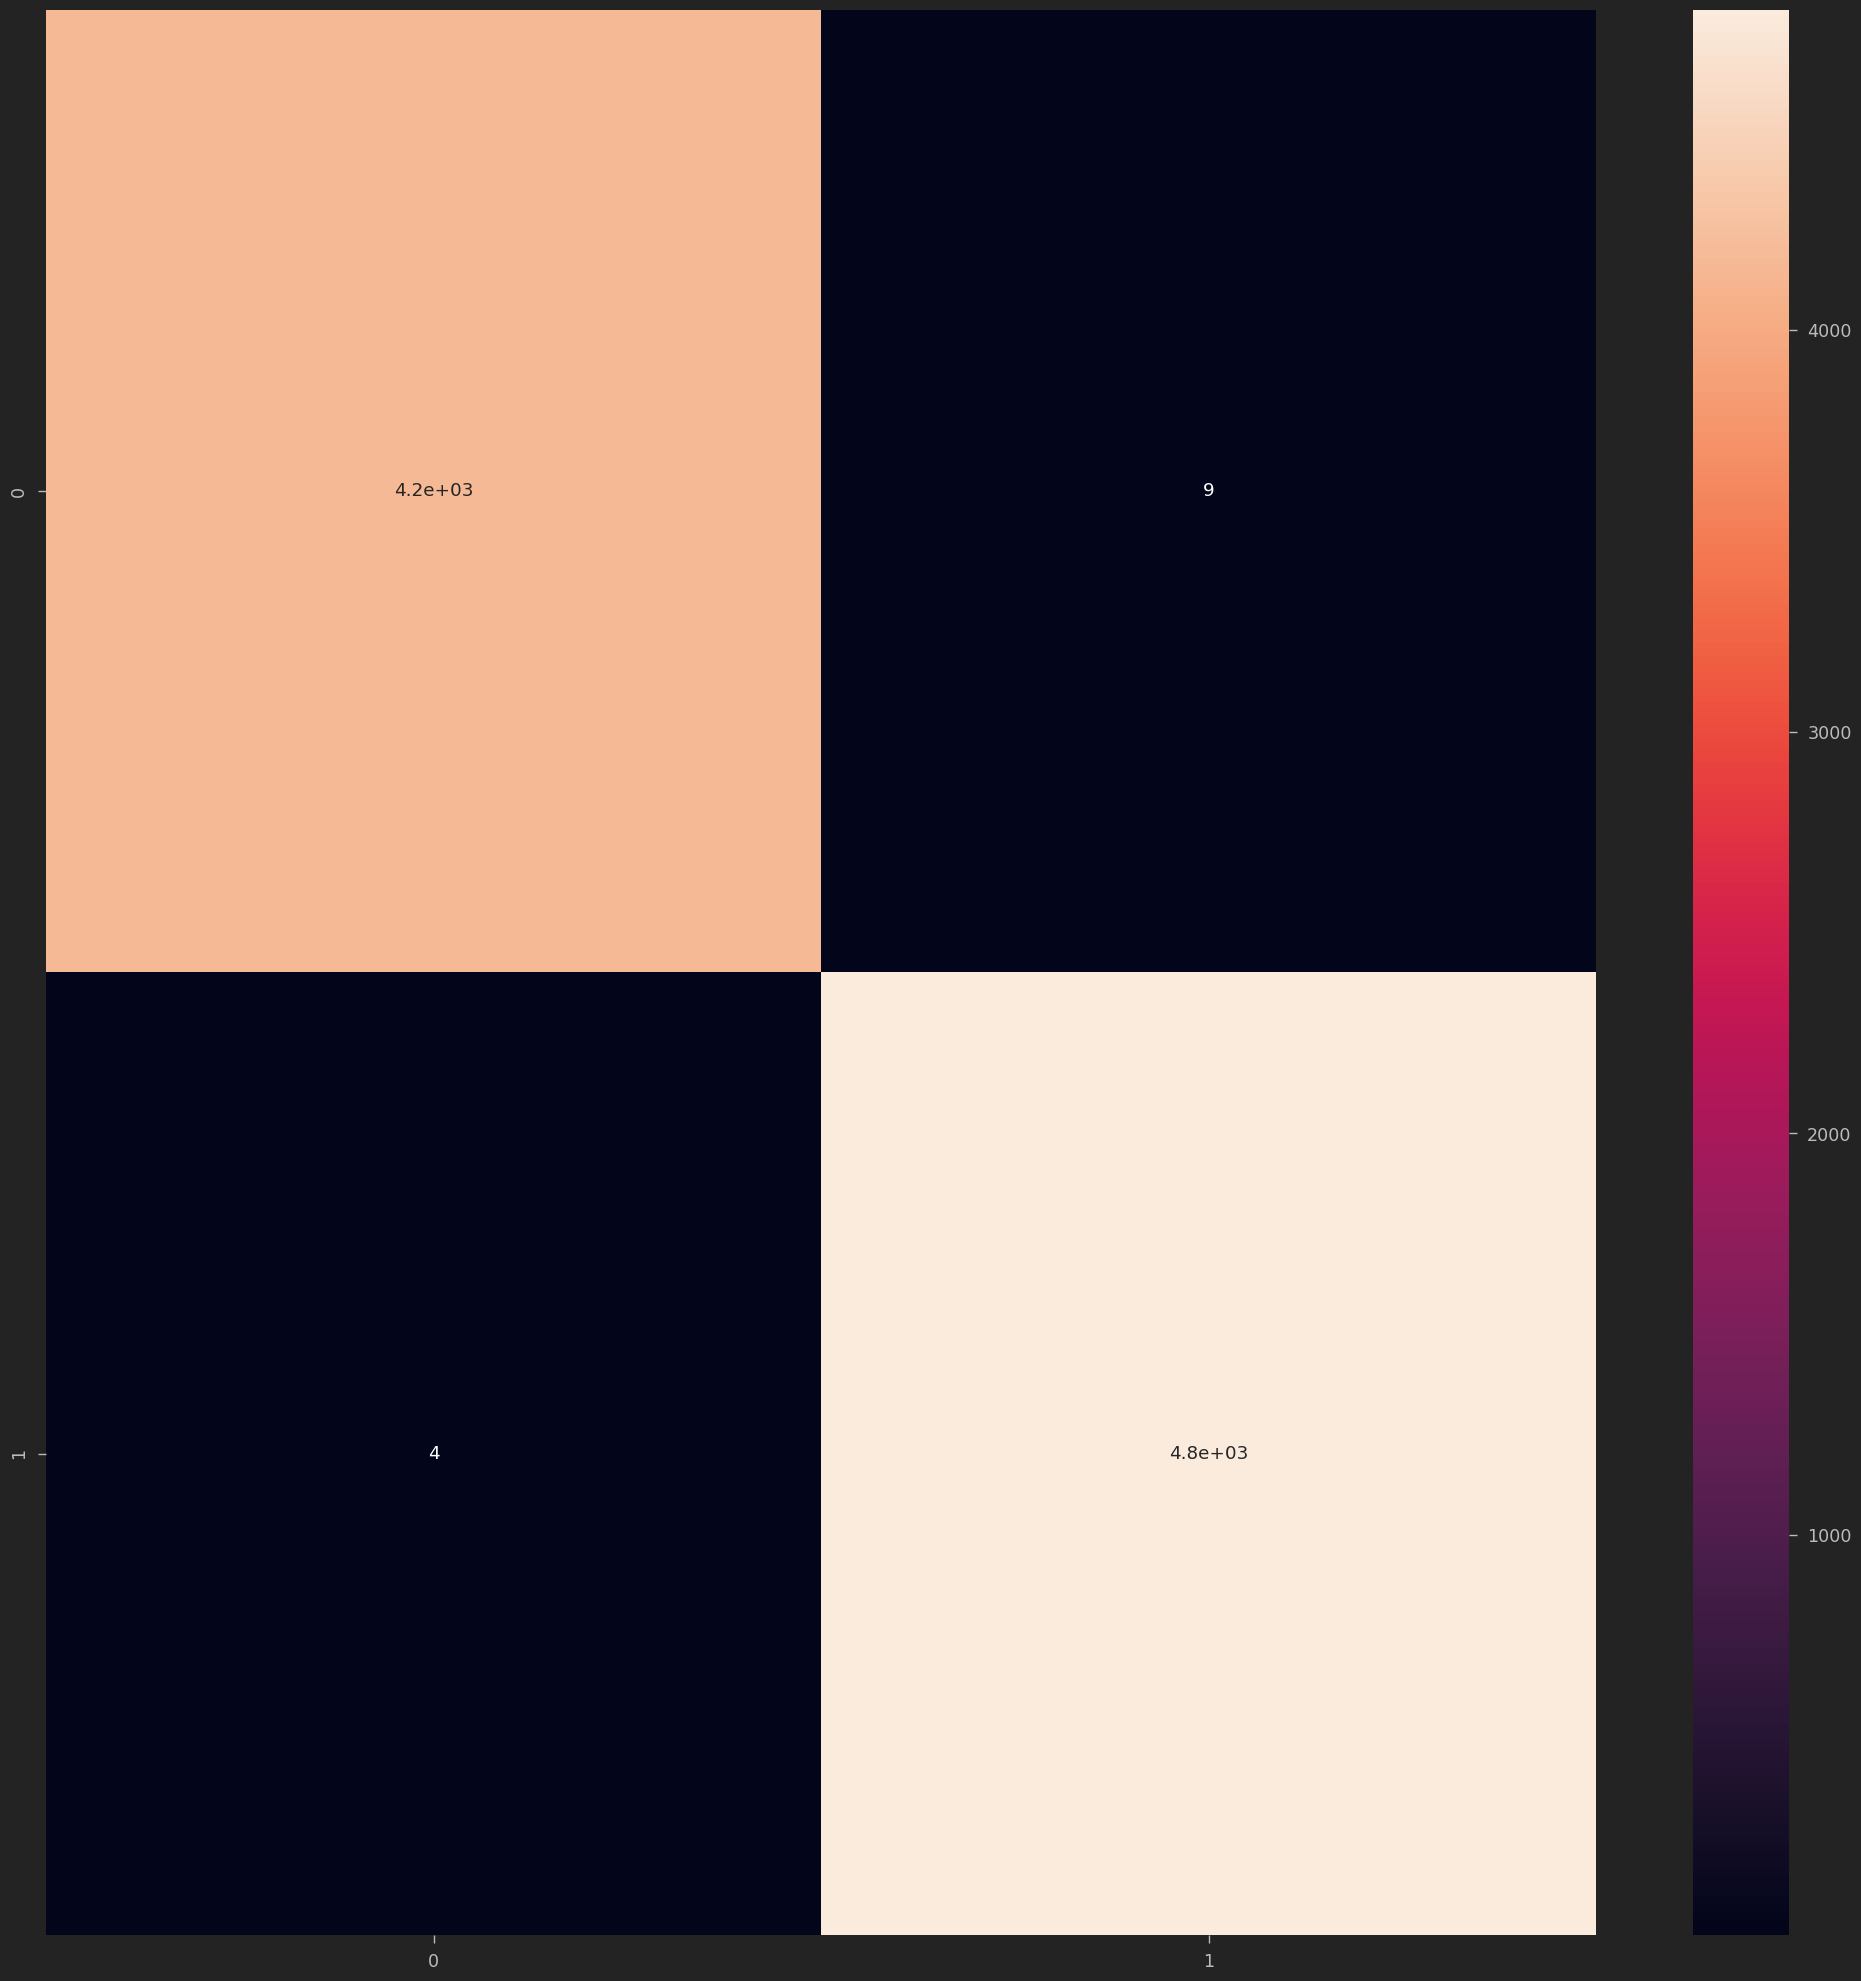

In [78]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

In [ ]:
# category dict
category = { 0: 'Fake News', 1 : "Real News"}